In [468]:
%pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user
%pip install opendatasets pandas numpy scikit-learn xgboost lightgbm tabulate category_encoders



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [469]:
#import some necessary librairies
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
#print(check_output(["dir", "C:/Users/anirb/aiml/UT-Austin-PGP/input/"]).decode("utf8")) #check the files available in the directory

# Loading the Training Data and using the Training Data to build the Model

## Data Loading

### Load Training

In [470]:
#Now let's import and put the train and test datasets in  pandas dataframe
folderPath = 'C:/Users/anirb/aiml/UT-Austin-PGP'
train = pd.read_csv(folderPath + '/input/train.csv')
test = pd.read_csv(folderPath + '/input/test.csv')


In [471]:
##display the first five rows of the test dataset.
test.head(5)


,Registration Number,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,Liquor License Obtained,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,20001,"tibetan,italian",Bangalore,Near Business Hub,13-07-2010,78.000,Tier A Celebrity,69.000,1,1,...,6.000,NaN,2.000,NaN,NaN,5,2,2,6,0
1,20002,"tibetan,italian",Hyderabad,Near Party Hub,05-09-2011,89.170,Not Specific,96.000,1,1,...,9.000,3.000,NaN,NaN,6.000,7,8,5,1,8
2,20003,"algerian,belgian",Hyderabad,Near Party Hub,12-04-2011,84.000,Not Specific,86.000,1,1,...,6.000,3.000,NaN,NaN,NaN,9,7,5,1,5
3,20004,"tibetan,greek",-1,Near Party Hub,16-01-2005,79.380,Not Specific,74.400,0,1,...,9.000,6.000,NaN,NaN,NaN,6,7,6,4,7
4,20005,"cuban,british",Pune,Near Party Hub,10-11-2008,84.670,Not Specific,86.460,1,1,...,NaN,NaN,NaN,NaN,NaN,4,4,7,7,3


In [472]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
# train_ID = train['Registration Number']
# test_ID = test[]

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
# train.drop("Registration Number", axis = 1, inplace = True)
# test.drop("Registration Number", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))
 


The train data size before dropping Id feature is : (3493, 34) 
The test data size before dropping Id feature is : (500, 33) 

The train data size after dropping Id feature is : (3493, 34) 
The test data size after dropping Id feature is : (500, 33) 


## Data Cleanup

### Target Variables


 mu = 30725708.56 and sigma = 21648147.45



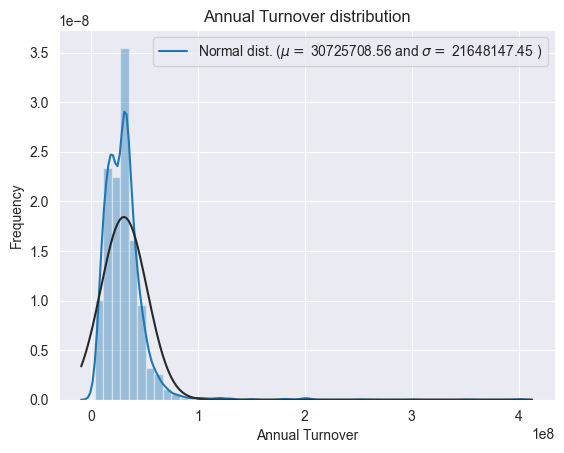

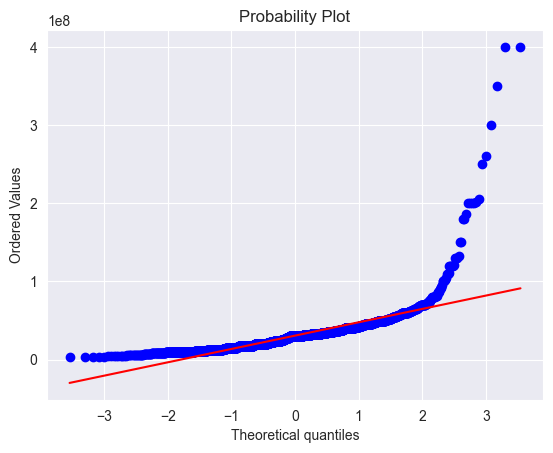

In [473]:
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()


 mu = 17.09 and sigma = 0.55



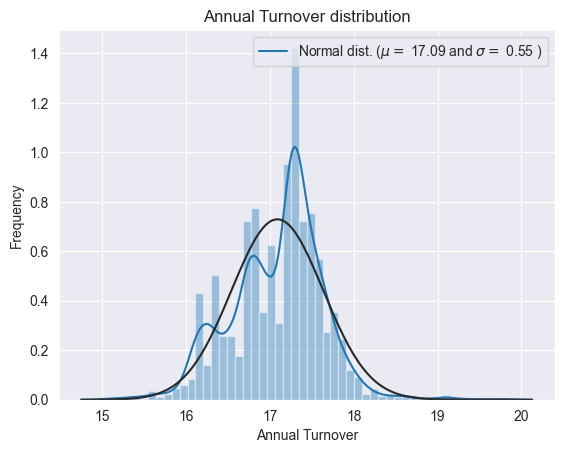

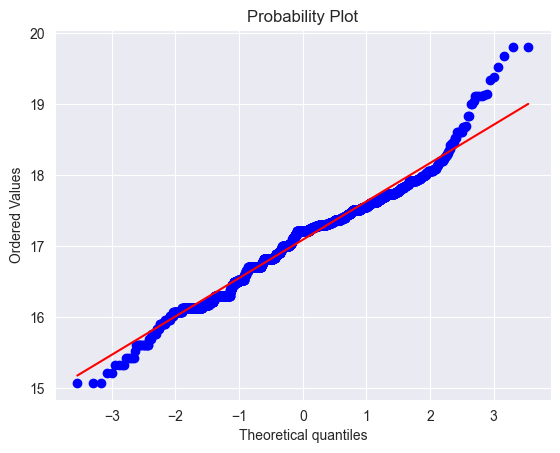

In [474]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["Annual Turnover"] = np.log1p(train["Annual Turnover"])

#Check the new distribution 
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()


In [475]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Annual Turnover'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (3993, 33)


### Fix City

In [476]:
all_data['City'] = all_data['City'].replace('-1', 'NOCITY')
all_data['City'] = all_data['City'].str.upper().str.strip()

In [477]:
replacement_pattern = r"^(BANGALORE|BANGLORE|BENGALURU|Asifabadbanglore|Banaglore)$"  # Consider using raw string for regex

# Replace matching values with 'BANGALORE' (case-sensitive)
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'BANGALORE')


replacement_pattern = r"^(BHUBANESHWAR|BHUBANESWAR|BHUBNESHWAR)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'BHUBANESHWAR')


replacement_pattern = r"^(TRIVANDRUM|THIRUVANANTHAPURAM|THIRUVANANTHAPURAM)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'TRIVANDRUM')

replacement_pattern = r"^(GURAGAON|GURGAON)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'GURAGAON')

replacement_pattern = r"^(NEW DEHLI|NEW DELHI)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'NEW DELHI')


replacement_pattern = r"^(VISAKHAPATNAM|VIZAG|VSAKHAPTTNAM)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'VIZAG')

all_data.loc[all_data['City'].isin((all_data['City'].value_counts()[all_data['City'].value_counts() < 6]).index), 'City'] = 'OTHER'

all_data['City'].value_counts().sort_values(ascending=False)



BANGALORE        684
NOCITY           461
NOIDA            389
HYDERABAD        368
PUNE             327
CHENNAI          313
OTHER            263
GURAGAON         218
NEW DELHI        205
MUMBAI           119
KOLKATA          119
JAIPUR            53
LUCKNOW           41
MYSORE            40
BHUBANESHWAR      40
NAVI MUMBAI       34
GREATER NOIDA     29
CHANDIGARH        28
INDORE            25
DELHI             21
COIMBATORE        21
BHOPAL            19
AHMEDABAD         19
FARIDABAD         18
TRIVANDRUM        17
GHAZIABAD         16
KOCHI/COCHIN      13
MOHALI            13
NAGPUR            11
VIZAG             11
DEHRADUN          11
MANGALORE         11
KANPUR             9
JABALPUR           7
THANE              7
PATNA              7
PONDICHERRY        6
Name: City, dtype: int64

In [478]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Live Sports Rating,94.140
Value Deals Rating,77.436
Comedy Gigs Rating,71.450
Live Music Rating,21.713
Overall Restaurant Rating,6.161
Facebook Popularity Quotient,2.479
Instagram Popularity Quotient,1.402
Resturant Tier,1.227
Ambience,0.626


Text(0.5, 1.0, 'Percent missing data by feature')

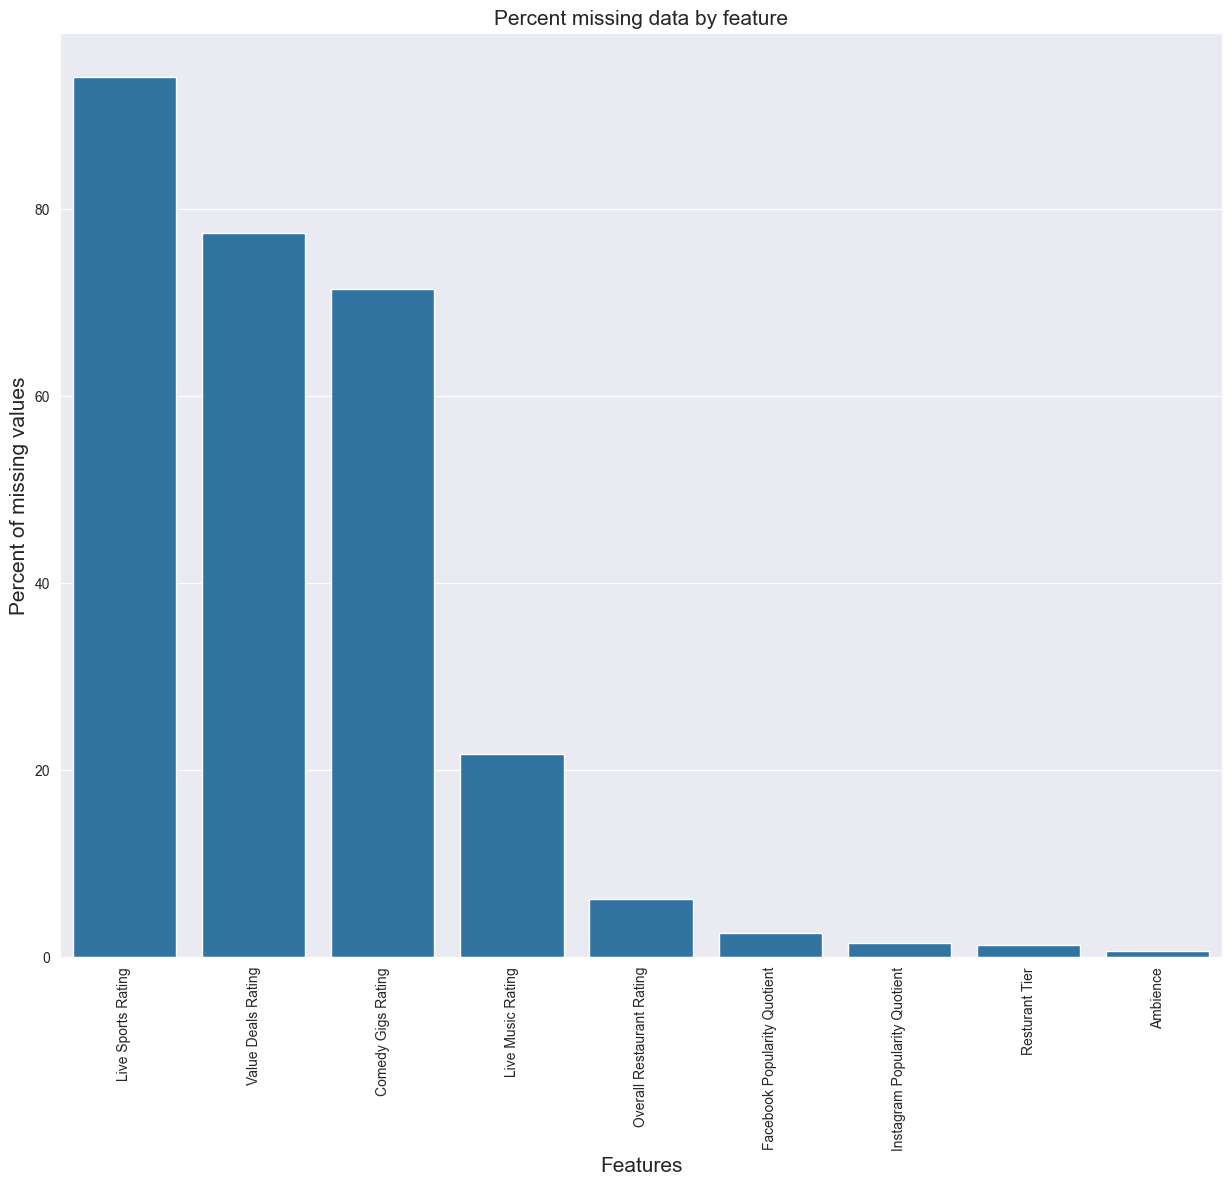

In [479]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

<Axes: >

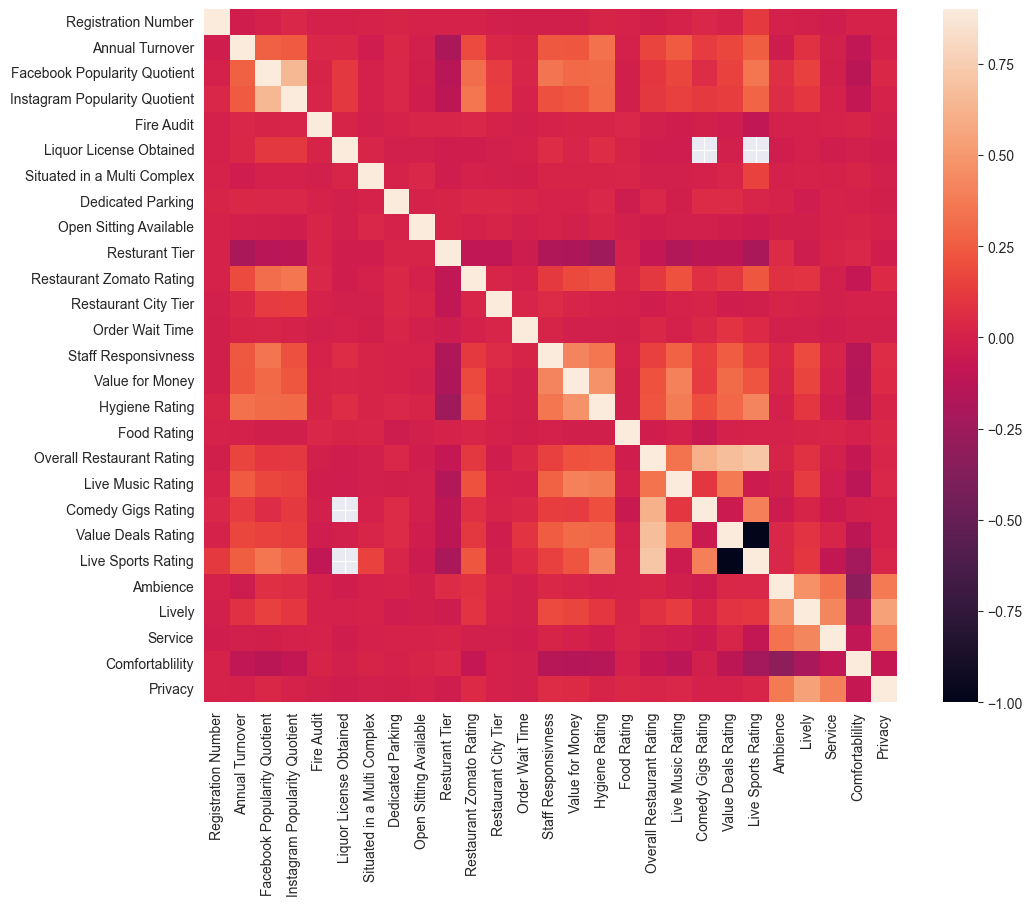

In [480]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,color='blue')

In [481]:
all_data["Live Sports Rating"] = all_data["Live Sports Rating"].transform(lambda x: x.fillna(x.median()))
all_data["Live Sports Rating"].value_counts(dropna=False)

4.000    3849
3.000      88
5.000      29
2.000      22
6.000       5
Name: Live Sports Rating, dtype: int64

In [482]:
all_data["Value Deals Rating"] = all_data["Value Deals Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Value Deals Rating'].value_counts(dropna=False)


4.000    3411
3.000     317
5.000     145
2.000      94
6.000      20
1.000       4
7.000       2
Name: Value Deals Rating, dtype: int64

In [483]:
all_data["Comedy Gigs Rating"] = all_data["Comedy Gigs Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Comedy Gigs Rating'].value_counts(dropna=False)


3.000    3371
2.000     317
4.000     221
5.000      47
1.000      35
6.000       2
Name: Comedy Gigs Rating, dtype: int64

In [484]:
all_data["Live Music Rating"] = all_data["Live Music Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Live Music Rating'].value_counts(dropna=False)


4.000    2144
3.000     780
5.000     723
6.000     183
2.000     112
1.000      32
7.000      17
8.000       2
Name: Live Music Rating, dtype: int64

In [485]:
all_data["Overall Restaurant Rating"] = all_data["Overall Restaurant Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Overall Restaurant Rating'].value_counts(dropna=False)


9.000     1421
10.000     975
7.000      657
8.000      602
6.000      338
Name: Overall Restaurant Rating, dtype: int64

In [486]:
all_data["Facebook Popularity Quotient"] = all_data["Facebook Popularity Quotient"].transform(lambda x: x.fillna(x.mean()))
all_data['Facebook Popularity Quotient'].value_counts(dropna=False)


77.888    99
78.000    70
82.000    68
73.000    65
76.000    65
          ..
92.100     1
63.660     1
90.010     1
82.560     1
78.280     1
Name: Facebook Popularity Quotient, Length: 841, dtype: int64

In [487]:
all_data["Instagram Popularity Quotient"] = all_data["Instagram Popularity Quotient"].transform(lambda x: x.fillna(x.mean()))
all_data['Instagram Popularity Quotient'].value_counts(dropna=False)

70.000    72
72.000    67
74.000    61
62.000    57
74.449    56
          ..
55.550     1
65.900     1
76.770     1
68.150     1
53.550     1
Name: Instagram Popularity Quotient, Length: 796, dtype: int64

In [488]:
all_data["Ambience"] = all_data["Ambience"].transform(lambda x: x.fillna(x.median()))
all_data['Ambience'].value_counts(dropna=False)


6.000     783
8.000     752
7.000     710
5.000     428
9.000     403
4.000     401
10.000    184
3.000     167
2.000     103
1.000      34
0.000      28
Name: Ambience, dtype: int64

In [489]:
all_data["Resturant Tier"] = all_data["Resturant Tier"].transform(lambda x: x.fillna(x.median()))
all_data['Resturant Tier'].value_counts(dropna=False)


2.000    3706
1.000     287
Name: Resturant Tier, dtype: int64

In [490]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### City Encoding

#### TE

In [491]:
# columns_to_replace = [col for col in train.columns if col != 'Annual Turnover']
# # Update train with corresponding columns from all_data (excluding Annual Turnover)
# train.update(all_data[:ntrain][columns_to_replace])
# # 
# #train = all_data[:ntrain]
# import category_encoders as ce
# encoder = ce.TargetEncoder()
# train['City_TE'] = encoder.fit_transform(train['City'],np.log1p( train['Annual Turnover']))


# # Assuming City_encoded in df_train has target means
# df_target_encoding = train[['City_TE', 'City']]  # Optional: Select relevant columns
# df_target_encoding = df_target_encoding.drop_duplicates()
# # # Assuming City_target_encoding exists in df_train_without_duplicates
# city_target_means = df_target_encoding.set_index('City')['City_TE'].to_dict()
# print(city_target_means)

# # # # Example usage on df_test (replace with your actual usage)
# test  = all_data[ntrain:]

# test['City_TE'] = test['City'].replace(city_target_means)
# # # print(test['City_TE'])
# all_data = pd.concat((train, test))
# all_data.drop(['Annual Turnover'], axis=1, inplace=True)
# #all_data.drop(['City'], axis=1, inplace=True)

# #test
# all_data

# # print(train['City_TE'])
# # df_test.head()



#### Binary Encoding

### Restaurant Theme TE

In [492]:
# columns_to_replace = [col for col in train.columns if col != 'Annual Turnover']
# # Update train with corresponding columns from all_data (excluding Annual Turnover)
# train.update(all_data[:ntrain][columns_to_replace])

# import category_encoders as ce
# encoder = ce.TargetEncoder()
# train['Theme_TE'] = encoder.fit_transform(train['Restaurant Theme'],np.log1p( train['Annual Turnover']))


# # Assuming City_encoded in df_train has target means
# df_target_encoding = train[['Theme_TE', 'Restaurant Theme']]  # Optional: Select relevant columns
# df_target_encoding = df_target_encoding.drop_duplicates()
# # # Assuming City_target_encoding exists in df_train_without_duplicates
# theme_target_means = df_target_encoding.set_index('Restaurant Theme')['Theme_TE'].to_dict()
# # print(city_target_means)

# # # Example usage on df_test (replace with your actual usage)
# test  = all_data[ntrain:]
# test['Theme_TE'] = test['Restaurant Theme'].replace(theme_target_means)
# # print(test['City_TE'])
# all_data = pd.concat((train, test))
# all_data.drop(['Annual Turnover'], axis=1, inplace=True)

# #all_data.drop('Restaurant Theme', axis=1, inplace=True)

# all_data

#### City Binary Encoding

In [493]:
#Create object for binary encoding
import category_encoders as ce

encoder= ce.BinaryEncoder(cols=['City'],return_df=True)

all_data = encoder.fit_transform(all_data)
#Original Data
all_data

,Registration Number,Cuisine,City_0,City_1,City_2,City_3,City_4,City_5,Restaurant Location,Opening Day of Restaurant,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,"indian,irish",0,0,0,0,0,1,Near Business Hub,14-02-2009,...,10.000,4.000,3.000,4.000,4.000,8.000,8,6,6,6
1,60002,"indian,irish",0,0,0,0,1,0,Near Party Hub,29-09-2008,...,9.000,4.000,4.000,4.000,4.000,5.000,7,7,3,8
2,60003,"tibetan,italian",0,0,0,0,1,1,Near Business Hub,30-07-2011,...,8.000,3.000,3.000,4.000,4.000,7.000,10,5,2,8
3,60004,"turkish,nigerian",0,0,0,1,0,0,Near Party Hub,30-11-2008,...,9.000,6.000,3.000,4.000,4.000,7.000,7,4,3,5
4,60005,"irish,belgian",0,0,0,1,0,1,Near Party Hub,22-02-2010,...,6.000,4.000,2.000,4.000,4.000,7.000,6,2,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,"indian,irish",0,0,0,1,1,1,Near Party Hub,08-09-2009,...,9.000,5.000,3.000,4.000,4.000,7.000,8,5,2,7
3989,20497,"tibetan,greek",0,0,0,0,0,1,Near Party Hub,20-06-2007,...,8.000,3.000,3.000,4.000,4.000,9.000,8,8,4,8
3990,20498,"indian,irish",0,0,0,0,0,1,Near Party Hub,19-06-2010,...,9.000,5.000,3.000,4.000,4.000,1.000,6,5,7,2
3991,20499,"tibetan,greek",0,0,0,0,1,1,Near Party Hub,23-08-2012,...,9.000,6.000,6.000,4.000,4.000,7.000,7,2,3,5


#### Theme Binary Encoding

In [494]:
#Create object for binary encoding
import category_encoders as ce

encoder= ce.BinaryEncoder(cols=['Restaurant Theme'],return_df=True)

all_data = encoder.fit_transform(all_data)
#Original Data
all_data

,Registration Number,Cuisine,City_0,City_1,City_2,City_3,City_4,City_5,Restaurant Location,Opening Day of Restaurant,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,"indian,irish",0,0,0,0,0,1,Near Business Hub,14-02-2009,...,10.000,4.000,3.000,4.000,4.000,8.000,8,6,6,6
1,60002,"indian,irish",0,0,0,0,1,0,Near Party Hub,29-09-2008,...,9.000,4.000,4.000,4.000,4.000,5.000,7,7,3,8
2,60003,"tibetan,italian",0,0,0,0,1,1,Near Business Hub,30-07-2011,...,8.000,3.000,3.000,4.000,4.000,7.000,10,5,2,8
3,60004,"turkish,nigerian",0,0,0,1,0,0,Near Party Hub,30-11-2008,...,9.000,6.000,3.000,4.000,4.000,7.000,7,4,3,5
4,60005,"irish,belgian",0,0,0,1,0,1,Near Party Hub,22-02-2010,...,6.000,4.000,2.000,4.000,4.000,7.000,6,2,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,"indian,irish",0,0,0,1,1,1,Near Party Hub,08-09-2009,...,9.000,5.000,3.000,4.000,4.000,7.000,8,5,2,7
3989,20497,"tibetan,greek",0,0,0,0,0,1,Near Party Hub,20-06-2007,...,8.000,3.000,3.000,4.000,4.000,9.000,8,8,4,8
3990,20498,"indian,irish",0,0,0,0,0,1,Near Party Hub,19-06-2010,...,9.000,5.000,3.000,4.000,4.000,1.000,6,5,7,2
3991,20499,"tibetan,greek",0,0,0,0,1,1,Near Party Hub,23-08-2012,...,9.000,6.000,6.000,4.000,4.000,7.000,7,2,3,5


### Cuisine Type TE

#### Cuisine Binary Encoding

In [495]:
#Create object for binary encoding
import category_encoders as ce

encoder= ce.BinaryEncoder(cols=['Cuisine'],return_df=True)

all_data = encoder.fit_transform(all_data)
#Original Data
all_data

,Registration Number,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,0,0,0,0,1,0,0,0,0,...,10.000,4.000,3.000,4.000,4.000,8.000,8,6,6,6
1,60002,0,0,0,0,1,0,0,0,0,...,9.000,4.000,4.000,4.000,4.000,5.000,7,7,3,8
2,60003,0,0,0,1,0,0,0,0,0,...,8.000,3.000,3.000,4.000,4.000,7.000,10,5,2,8
3,60004,0,0,0,1,1,0,0,0,1,...,9.000,6.000,3.000,4.000,4.000,7.000,7,4,3,5
4,60005,0,0,1,0,0,0,0,0,1,...,6.000,4.000,2.000,4.000,4.000,7.000,6,2,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,0,0,0,0,1,0,0,0,1,...,9.000,5.000,3.000,4.000,4.000,7.000,8,5,2,7
3989,20497,0,0,1,0,1,0,0,0,0,...,8.000,3.000,3.000,4.000,4.000,9.000,8,8,4,8
3990,20498,0,0,0,0,1,0,0,0,0,...,9.000,5.000,3.000,4.000,4.000,1.000,6,5,7,2
3991,20499,0,0,1,0,1,0,0,0,0,...,9.000,6.000,6.000,4.000,4.000,7.000,7,2,3,5


In [496]:
# columns_to_replace = [col for col in train.columns if col != 'Annual Turnover']
# # Update train with corresponding columns from all_data (excluding Annual Turnover)
# train.update(all_data[:ntrain][columns_to_replace])

# import category_encoders as ce
# encoder = ce.TargetEncoder()
# train['Cuisine_TE'] = encoder.fit_transform(train['Cuisine'],np.log1p( train['Annual Turnover']))


# # Assuming City_encoded in df_train has target means
# df_target_encoding = train[['Cuisine_TE', 'Cuisine']]  # Optional: Select relevant columns
# df_target_encoding = df_target_encoding.drop_duplicates()
# # # Assuming City_target_encoding exists in df_train_without_duplicates
# cuisine_target_means = df_target_encoding.set_index('Cuisine')['Cuisine_TE'].to_dict()
# # print(city_target_means)

# # # Example usage on df_test (replace with your actual usage)
# test  = all_data[ntrain:]
# test['Cuisine_TE'] = test['Cuisine'].replace(cuisine_target_means)
# # print(test['City_TE'])
# all_data = pd.concat((train, test))
# all_data.drop(['Annual Turnover'], axis=1, inplace=True)

# #all_data.drop(['Cuisine'], axis=1, inplace=True)

# all_data

In [497]:
#all_data = pd.concat([all_data.drop('Cuisine', 1), all_data['Cuisine'].str.get_dummies()], 1)

In [498]:
# all_data = pd.concat([all_data.drop('Resturent Tier', 1), all_data['Resturent Tier'].str.get_dummies()], 1)

In [499]:
#all_data = pd.concat([all_data.drop('Restaurant Location', 1), all_data['Restaurant Location'].str.get_dummies()], 1)

In [500]:
all_data = pd.get_dummies(all_data,columns=["Restaurant Location"])

all_data = pd.get_dummies(all_data,columns=["Fire Audit"])
all_data = pd.get_dummies(all_data,columns=["Liquor License Obtained"])
all_data = pd.get_dummies(all_data,columns=["Situated in a Multi Complex"])
all_data = pd.get_dummies(all_data,columns=["Dedicated Parking"])

all_data = pd.get_dummies(all_data,columns=["Open Sitting Available"])
all_data = pd.get_dummies(all_data,columns=["Restaurant Zomato Rating"])
all_data = pd.get_dummies(all_data,columns=["Order Wait Time"])
all_data = pd.get_dummies(all_data,columns=["Restaurant City Tier"])
all_data = pd.get_dummies(all_data,columns=["Hygiene Rating"])
all_data = pd.get_dummies(all_data,columns=["Food Rating"])
all_data = pd.get_dummies(all_data,columns=["Overall Restaurant Rating"])

all_data = pd.get_dummies(all_data,columns=["Staff Responsivness"])
all_data = pd.get_dummies(all_data,columns=["Value for Money"])
all_data = pd.get_dummies(all_data,columns=["Live Music Rating"])
all_data = pd.get_dummies(all_data,columns=["Comedy Gigs Rating"])
all_data = pd.get_dummies(all_data,columns=["Value Deals Rating"])

all_data = pd.get_dummies(all_data,columns=["Live Sports Rating"])
all_data = pd.get_dummies(all_data,columns=["Ambience"])
all_data = pd.get_dummies(all_data,columns=["Lively"])
all_data = pd.get_dummies(all_data,columns=["Service"])
all_data = pd.get_dummies(all_data,columns=["Comfortablility"])
all_data = pd.get_dummies(all_data,columns=["Privacy"])

all_data = pd.get_dummies(all_data,columns=["Restaurant Type"])

# all_data = pd.get_dummies(all_data,columns=["Cuisine"])
all_data = pd.get_dummies(all_data,columns=["Endorsed By"])






# 'Restaurant Type', 'Staff Responsivness',
#        'Value for Money', 'Live Music Rating', 'Comedy Gigs Rating',
#        'Value Deals Rating', 'Live Sports Rating', 'Ambience', 'Lively',
#        'Service', 'Comfortablility', 'Privacy'


In [501]:
all_data.columns

Index(['Registration Number', 'Cuisine_0', 'Cuisine_1', 'Cuisine_2',
       'Cuisine_3', 'Cuisine_4', 'City_0', 'City_1', 'City_2', 'City_3',
       ...
       'Privacy_8', 'Privacy_9', 'Privacy_10', 'Restaurant Type_Bar',
       'Restaurant Type_Buffet/Family Restaurant', 'Restaurant Type_Caffee',
       'Restaurant Type_Gastro Bar', 'Endorsed By_Local Celebrity',
       'Endorsed By_Not Specific', 'Endorsed By_Tier A Celebrity'],
      dtype='object', length=175)

In [502]:
# columnsToOHE = ['Cuisine','Restaurant Location',
#        'Endorsed By',  'Fire Audit',
#        'Liquor License Obtained', 'Situated in a Multi Complex',
#        'Dedicated Parking', 'Open Sitting Available', 
#        'Restaurant Type',  'Restaurant Zomato Rating',
#        'Restaurant City Tier', 'Order Wait Time', 'Staff Responsivness',
#        'Value for Money', 'Hygiene Rating', 'Food Rating',
#        'Overall Restaurant Rating', 'Live Music Rating', 'Comedy Gigs Rating',
#        'Value Deals Rating', 'Live Sports Rating', 'Ambience', 'Lively',
#        'Service', 'Comfortablility', 'Privacy']

# # prefixes = ["Cuisine",'Location',
# #        'Endorsed',  'Fire',
# #        'Liquor', 'MultiComplex',
# #        'Parking', 'OpenSitting', 
# #        'RestaurantType',  'RestaurantZomato',
# #        'CityTier', 'OrderWaitTime', 'Staff',
# #        'ValueMoney', 'HygieneRating', 'FoodRating',
# #        'OverallRating', 'LiveMusic', 'ComedyGigs',
# #        'ValueDeals', 'LiveSports', 'Ambience', 'Lively',
# #        'Service', 'Comfortablility', 'Privacy']

# # for col in columnsToOHE:
# #   all_data = pd.get_dummies(all_data, columns=[col])  # Encode each column separately

# # pd.get_dummies(all_data , columns=columnsToOHE)
# #all_data = pd.get_dummies(all_data,  columns=['Cuisine'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])
# # pd.get_dummies(all_data, prefix='Fire' , columns=['Fire Audit'])

# #all_data = pd.concat([all_data.drop('Fire Audit', 1), all_data['Fire Audit'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Liquor License Obtained', 1), all_data['Liquor License Obtained'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Situated in a Multi Complex', 1), all_data['Situated in a Multi Complex'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Open Sitting Available', 1), all_data['Open Sitting Available'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Order Wait Time', 1), all_data['Order Wait Time'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Staff Responsivness', 1), all_data['Staff Responsivness'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Value for Money', 1), all_data['Value for Money'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Hygiene Rating', 1), all_data['Hygiene Rating'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Food Rating', 1), all_data['Food Rating'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Live Music Rating', 1), all_data['Live Music Rating'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Comedy Gigs Rating', 1), all_data['Comedy Gigs Rating'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Value Deals Rating', 1), all_data['Value Deals Rating'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Ambience', 1), all_data['Ambience'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Lively', 1), all_data['Lively'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Service', 1), all_data['Service'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Comfortablility', 1), all_data['Comfortablility'].str.get_dummies()], 1)
# # all_data = pd.concat([all_data.drop('Privacy', 1), all_data['Privacy'].str.get_dummies()], 1)
# all_data.columns()


In [503]:
# all_data = pd.concat([all_data.drop('Endorsed By', 1), all_data['Endorsed By'].str.get_dummies()], 1)


In [504]:
# all_data = pd.concat([all_data.drop('Restaurant Type', 1), all_data['Restaurant Type'].str.get_dummies()], 1)
# all_data

### Date Field

In [505]:
#all_data['Opening Day of Restaurant'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y')
#print(all_data['Opening Day of Restaurant'].dtype)
launch_date = datetime.datetime(2015, 3, 23)
# scale days open
all_data['Days Open'] = (launch_date - pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y')).dt.days / 1000
all_data['Opening Year'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y').dt.year
all_data['Opening Month'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y').dt.month
#all_data['Opening Year'].astype(str)
all_data['Opening Month'].value_counts()

all_data.drop('Opening Day of Restaurant', axis=1, inplace=True)
all_data


,Registration Number,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,...,Restaurant Type_Bar,Restaurant Type_Buffet/Family Restaurant,Restaurant Type_Caffee,Restaurant Type_Gastro Bar,Endorsed By_Local Celebrity,Endorsed By_Not Specific,Endorsed By_Tier A Celebrity,Days Open,Opening Year,Opening Month
0,60001,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,2.228,2009,2
1,60002,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,2.366,2008,9
2,60003,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1.332,2011,7
3,60004,0,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,1,2.304,2008,11
4,60005,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1.855,2010,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,2.022,2009,9
3989,20497,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,2.833,2007,6
3990,20498,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,1.738,2010,6
3991,20499,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0.942,2012,8


#### Year Month OHE

In [506]:
all_data = pd.get_dummies(all_data,columns=["Opening Year"])
all_data = pd.get_dummies(all_data,columns=["Opening Month"])

all_data


,Registration Number,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,...,Opening Month_3,Opening Month_4,Opening Month_5,Opening Month_6,Opening Month_7,Opening Month_8,Opening Month_9,Opening Month_10,Opening Month_11,Opening Month_12
0,60001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60002,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,60003,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,60004,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,60005,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3989,20497,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3990,20498,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3991,20499,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [507]:
# all_data.drop(['City'], axis=1, inplace=True)
# all_data.drop(['Cuisine'], axis=1, inplace=True)
# all_data.drop(['Restaurant Theme'], axis=1, inplace=True)
all_data

,Registration Number,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,...,Opening Month_3,Opening Month_4,Opening Month_5,Opening Month_6,Opening Month_7,Opening Month_8,Opening Month_9,Opening Month_10,Opening Month_11,Opening Month_12
0,60001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60002,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,60003,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,60004,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,60005,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3989,20497,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3990,20498,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3991,20499,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [508]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]
df_train = pd.concat([y_train['Annual Turnover'],df_train], axis=1)
df_test

,Registration Number,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,...,Opening Month_3,Opening Month_4,Opening Month_5,Opening Month_6,Opening Month_7,Opening Month_8,Opening Month_9,Opening Month_10,Opening Month_11,Opening Month_12
3493,20001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3494,20002,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3495,20003,0,0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3496,20004,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3497,20005,0,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,20496,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3989,20497,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3990,20498,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3991,20499,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [509]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(15, 7))
# sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral") # Complete the code to get the heatmap of the data
# plt.show()

#### Remove High Correl

In [510]:
threshold = 0.85
# Calculate the correlation matrix
corr_matrix = all_data.corr()
iters = range(len(corr_matrix.columns) - 1)
drop_cols = []

    # Iterate through the correlation matrix and compare correlations
for i in iters:
    for j in range(i+1):
        item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
        col = item.columns
        row = item.index
        val = abs(item.values)

        # If correlation exceeds the threshold
        if val >= threshold:
            # Print the correlated features and the correlation value
            #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
            drop_cols.append(col.values[0])

# Drop one of each pair of correlated columns
print(len(drop_cols))
drops = set(drop_cols)
all_data = all_data.drop(columns=drops)

9


### Scalers

In [511]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

numeric = ['Facebook Popularity Quotient', 'Instagram Popularity Quotient',
      'Days Open'
]

# Fit the MinMaxScaler to the training data
scaler.fit(all_data)

# Use the scaler to transform the training and test sets
all_data[numeric] = scaler.fit_transform(all_data[numeric])
# val_inputs[numeric] = scaler.fit_transform(val_inputs[numeric])
# X_test_scaled = scaler.transform(val_inputs)
# df_test[numeric]= scaler.fit_transform(df_test[numeric])

## Split Train and Test

In [512]:
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

len(train_df), len(val_df) , len(df_test)

(2794, 699, 500)

## Train and Validation Dataset

In [513]:
train_targets = train_df['Annual Turnover']
# Column to exclude
columns_to_exclude = ['Annual Turnover','Registration Number']
# Select all columns except 'col2' (using drop with subset and inplace=False)

train_inputs  = train_df.drop(columns_to_exclude, axis=1, inplace=False)  # Keep original intact
val_inputs = val_df.drop(columns_to_exclude, axis=1, inplace=False)  
val_targets = val_df['Annual Turnover']

### Scale

In [514]:
# from sklearn.preprocessing import MinMaxScaler

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# numeric = ['Facebook Popularity Quotient', 'Instagram Popularity Quotient',
#       'Days Open'
# ]

# # Fit the MinMaxScaler to the training data
# scaler.fit(train_inputs)

# # Use the scaler to transform the training and test sets
# train_inputs[numeric] = scaler.fit_transform(train_inputs[numeric])
# val_inputs[numeric] = scaler.fit_transform(val_inputs[numeric])
# # X_test_scaled = scaler.transform(val_inputs)
# df_test[numeric]= scaler.fit_transform(df_test[numeric])

# Try Different Models

#### Change Column Names

In [515]:
import re
train_inputs = train_inputs.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
val_inputs = val_inputs.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test = df_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## Linear Regression

In [516]:
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(train_inputs, train_targets)
LinearRegression()


LinearRegression()

In [517]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [518]:
train_preds = linreg_model.predict(train_inputs)
val_preds = linreg_model.predict(val_inputs)

#row_61946 = val_inputs.loc[df_train['Registration Number'] == 61946]
#print(row_61946)
#val_preds_RN = linreg_model.predict(row_61946)
#validation_mse_RN = np.sqrt(mean_squared_error([22000000], val_preds_RN))
#print(validation_mse_RN)

In [519]:
train_rmse_linreg = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_linreg = np.sqrt(mean_squared_error(val_preds, val_targets))
print(f'Train RMSE Linear Reg: {train_rmse_linreg:n}')
print(f'Test RMSE Linear Reg: {test_rmse_linreg:n}')
import matplotlib.pyplot as plt


Train RMSE Linear Reg: 0.452096
Test RMSE Linear Reg: 1.687e+08


## Ridge Linear Regression


In [520]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


params_ridge = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
#    'normalize' : [True,False],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge_model = Ridge()
ridge_regressor = GridSearchCV(ridge_model, params_ridge, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(train_inputs, train_targets)
# print(f'Optimal alpha: {ridge_regressor.best_params_["alpha"]:.2f}')
# print(f'Optimal fit_intercept: {ridge_regressor.best_params_["fit_intercept"]}')
# #print(f'Optimal normalize: {ridge_regressor.best_params_["normalize"]}')
# print(f'Optimal solver: {ridge_regressor.best_params_["solver"]}')
# print(f'Best score: {ridge_regressor.best_score_}')

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 5,
                                   10, 20],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring='neg_root_mean_squared_error')

In [521]:
ridge_model = Ridge(alpha=ridge_regressor.best_params_["alpha"], fit_intercept=ridge_regressor.best_params_["fit_intercept"], 
                    solver=ridge_regressor.best_params_["solver"])
ridge_model.fit(train_inputs, train_targets)
train_preds = ridge_model.predict(train_inputs)
val_preds = ridge_model.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_ridge = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_ridge = np.sqrt(mean_squared_error(val_preds, val_targets))
print(f'Train RMSE Ridge: {train_rmse_ridge:n}')
print(f'Test RMSE Ridge: {test_rmse_ridge:n}')

Train r2 score:  -1.4992149198134443
Test r2 score:  0.24165400961089722
Train RMSE Ridge: 0.456102
Test RMSE Ridge: 0.475013


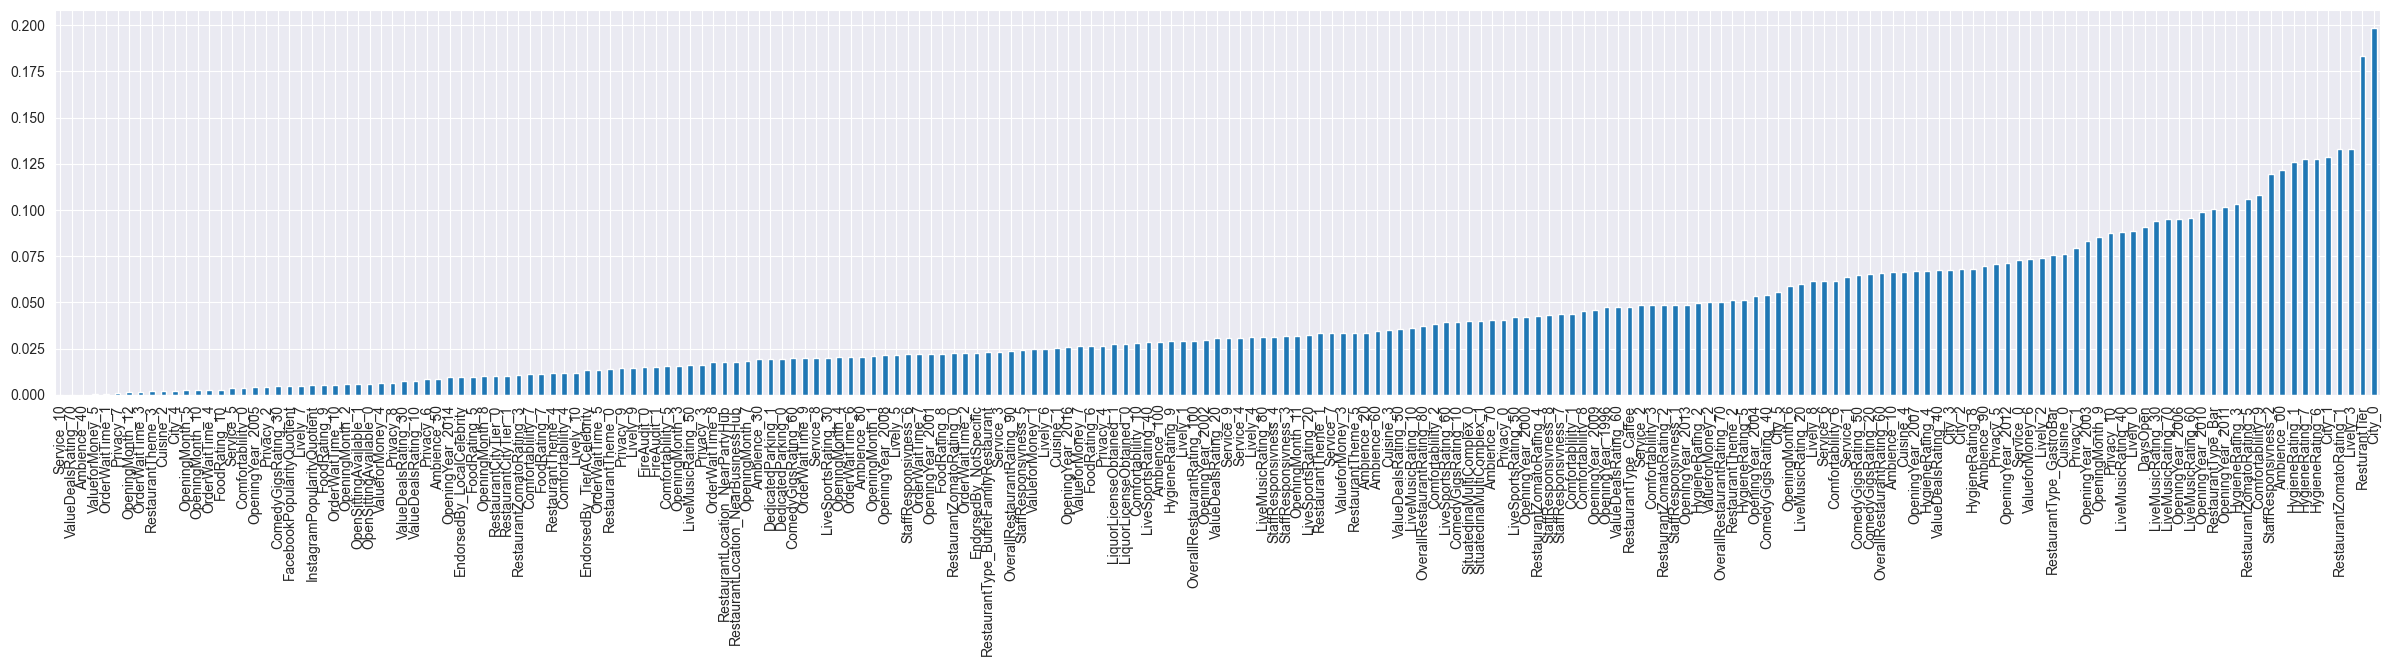

In [522]:
# Lasso Model Feature Importance
lasso_feature_coef = pd.Series(index = train_inputs.columns, data = np.abs(ridge_model.coef_))
lasso_feature_coef.sort_values().plot(kind = 'bar', figsize = (30,5));

## Lasso Model

In [523]:
params_lasso = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
}

lasso_model = Lasso()
lasso_regressor = GridSearchCV(lasso_model, params_lasso, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
lasso_regressor.fit(train_inputs, train_targets)
print(f'Optimal alpha: {lasso_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {lasso_regressor.best_params_["fit_intercept"]}')
print(f'Best score: {lasso_regressor.best_score_}')

Optimal alpha: 0.01
Optimal fit_intercept: True
Best score: -0.49426110306237875


In [524]:
lasso_model = Lasso(alpha=lasso_regressor.best_params_["alpha"], fit_intercept=lasso_regressor.best_params_["fit_intercept"], 
                    )
lasso_model.fit(train_inputs, train_targets)
train_preds = lasso_model.predict(train_inputs)
val_preds = lasso_model.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_lasso = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_lasso = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE: {train_rmse_lasso:.4f}')
print(f'Test RMSE: {test_rmse_lasso:.4f}')

Train r2 score:  -4.825037582912397
Test r2 score:  0.2019021198529255
Train RMSE: 0.4904
Test RMSE: 0.4873


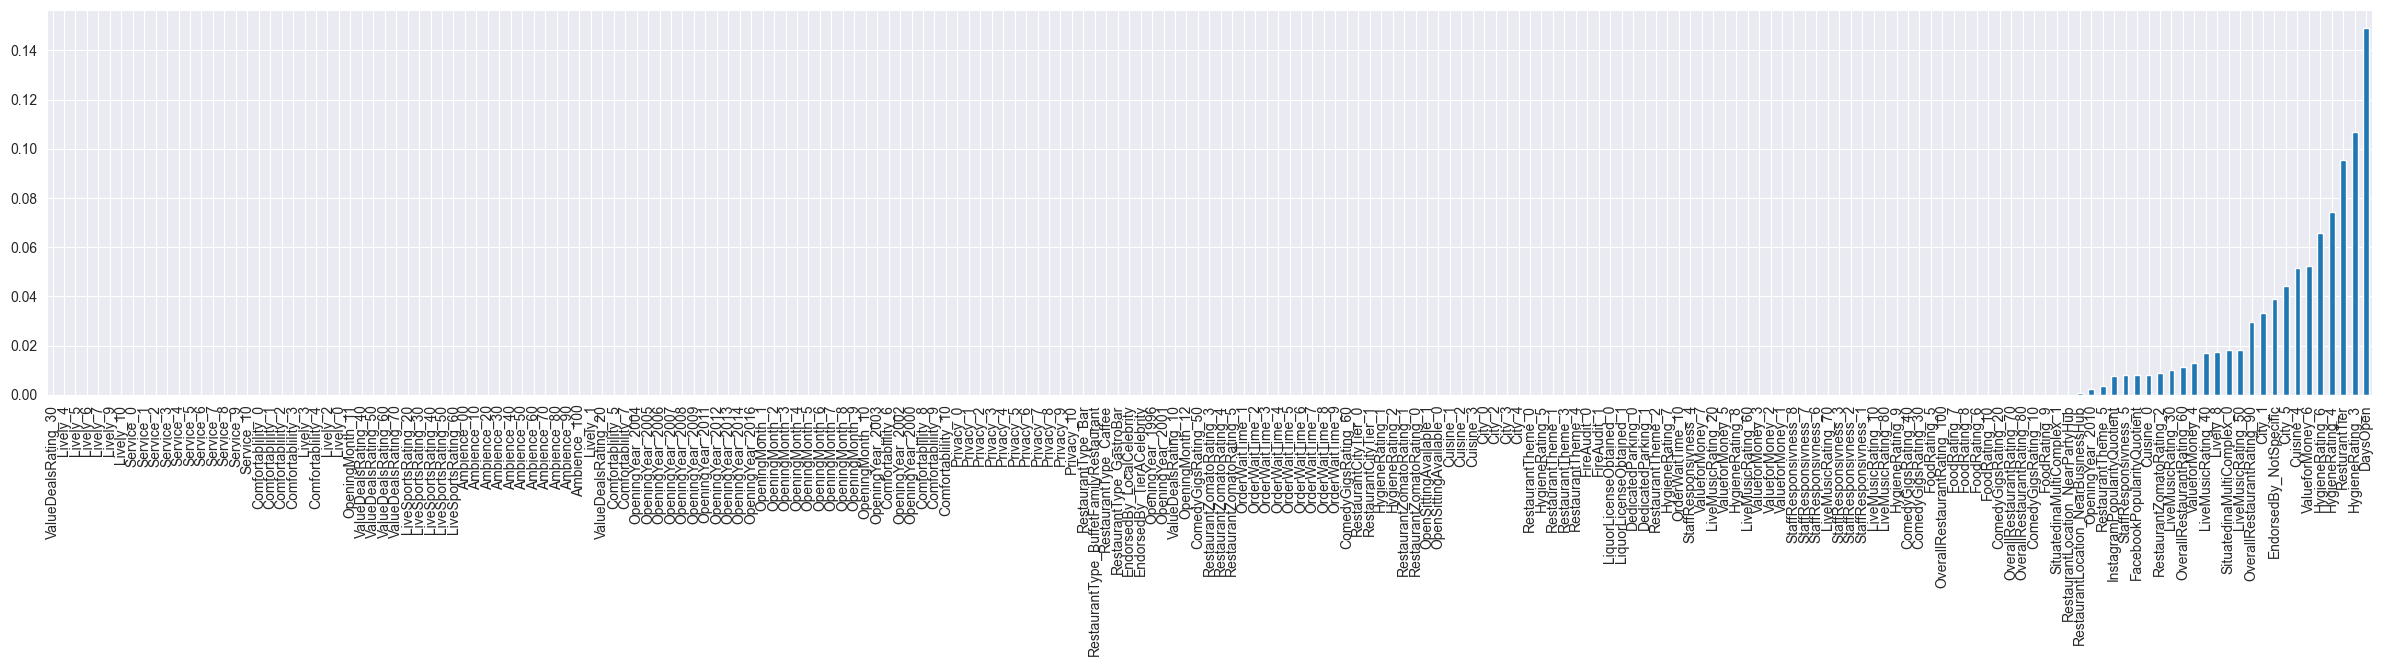

In [525]:
# Lasso Model Feature Importance
lasso_feature_coef = pd.Series(index = train_inputs.columns, data = np.abs(lasso_model.coef_))
lasso_feature_coef.sort_values().plot(kind = 'bar', figsize = (30,5));

## XG Boost Model

In [526]:
from xgboost import XGBRegressor, plot_importance
# Scale the data using StandardScaler
from sklearn.preprocessing import StandardScaler


params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(train_inputs, train_targets)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

Optimal lr: 0.1
Optimal colsample_bytree: 0.5
Optimal n_estimators: 70
Best score: -0.4822062578806915


In [527]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(train_inputs, train_targets)

train_preds = xgb_model.predict(train_inputs)
val_preds = xgb_model.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_xgb = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_xgb = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE XGB: {train_rmse_xgb:n}')
print(f'Test RMSE XGB: {test_rmse_xgb:n}')

Train r2 score:  -1.8518157745867851
Test r2 score:  0.25321795199969044
Train RMSE XGB: 0.435689
Test RMSE XGB: 0.471377


150 features with reduction of 26.11%


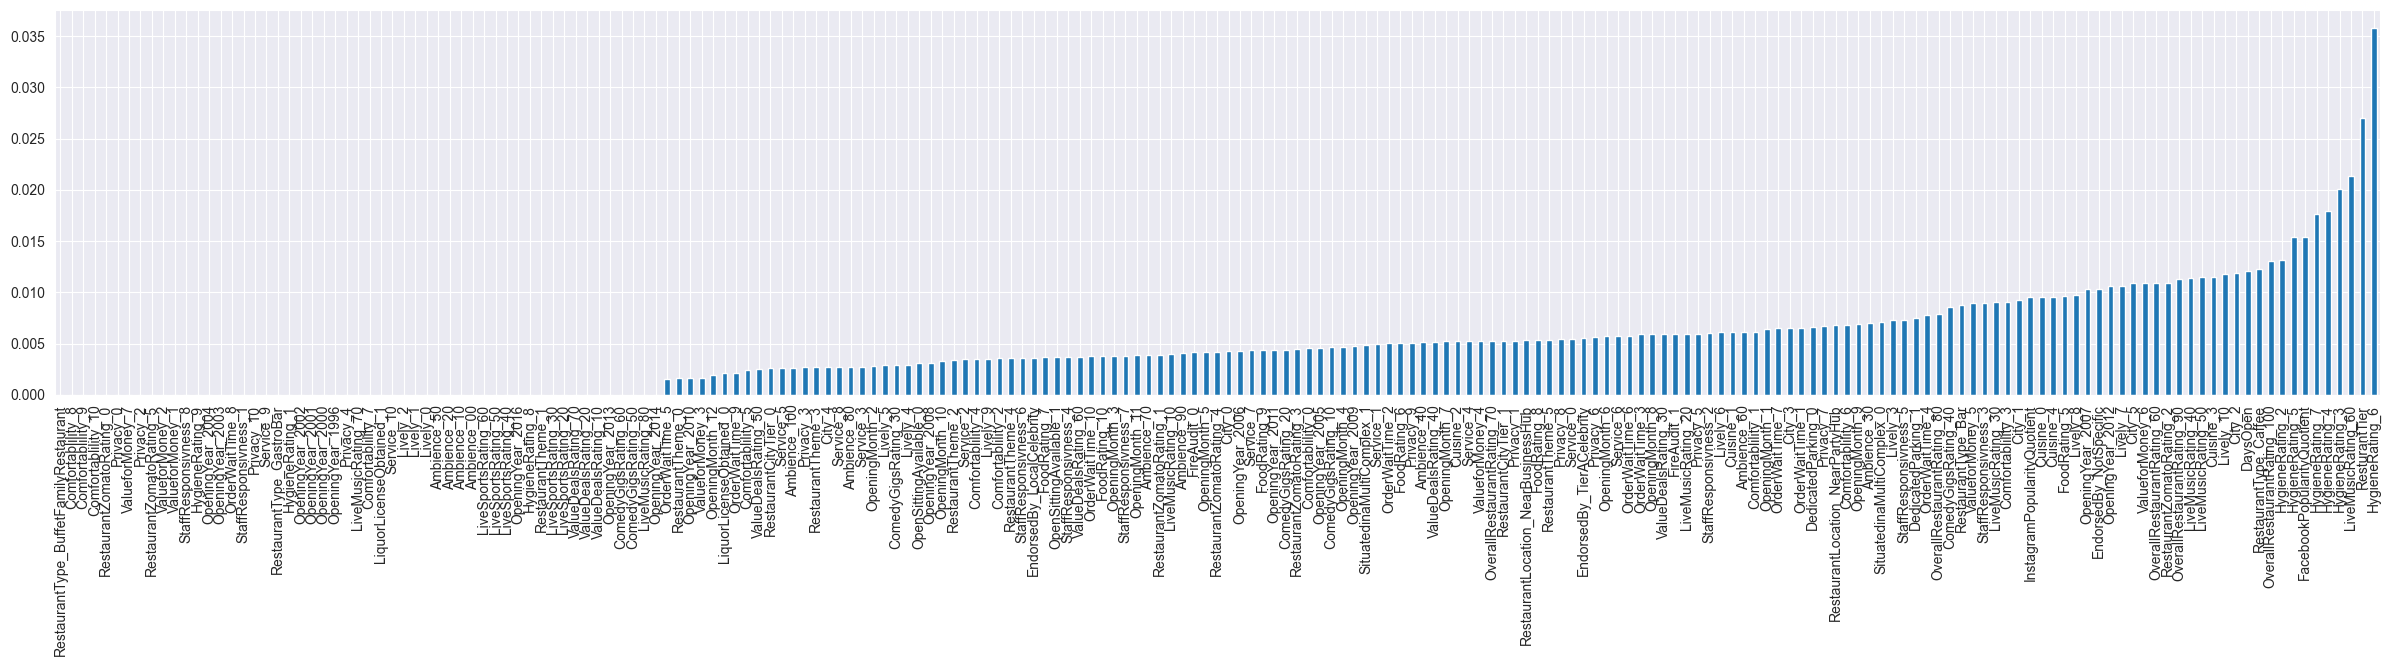

In [528]:
# XG Forest Model Feature Importance
rf_feature_importance = pd.Series(index = train_inputs.columns, data = np.abs(xgb_model.feature_importances_))
n_features = (rf_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')
rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (30,5));

## Random Forest Regressor

### Grid Search

In [529]:
# from sklearn.ensemble import RandomForestRegressor

# params_rf = {
#     'max_depth': [10, 30, 35, 50, 65, 75, 100],
#     'max_features': [.3, .4, .5, .6],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [30, 50, 100, 200]
# }

# rf = RandomForestRegressor()
# rf_regressor = GridSearchCV(rf, params_rf, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
# rf_regressor.fit(train_inputs, train_targets)
# print(f'Optimal depth: {rf_regressor.best_params_["max_depth"]}')
# print(f'Optimal max_features: {rf_regressor.best_params_["max_features"]}')
# print(f'Optimal min_sample_leaf: {rf_regressor.best_params_["min_samples_leaf"]}')
# print(f'Optimal min_samples_split: {rf_regressor.best_params_["min_samples_split"]}')
# print(f'Optimal n_estimators: {rf_regressor.best_params_["n_estimators"]}')
# print(f'Best score: {rf_regressor.best_score_}')

In [530]:
# rf_model = RandomForestRegressor(max_depth=rf_regressor.best_params_["max_depth"], 
#                                  max_features=rf_regressor.best_params_["max_features"], 
#                                  min_samples_leaf=rf_regressor.best_params_["min_samples_leaf"], 
#                                  min_samples_split=rf_regressor.best_params_["min_samples_split"], 
#                                  n_estimators=rf_regressor.best_params_["n_estimators"], 
#                                  n_jobs=-1, oob_score=True)
# rf_model.fit(train_inputs, train_targets)
# train_preds = rf_model.predict(train_inputs)
# val_preds = rf_model.predict(val_inputs)
# print('Train r2 score: ', r2_score(train_preds, train_targets))
# print('Test r2 score: ', r2_score(val_preds,val_targets ))
# train_rmse = np.sqrt(mean_squared_error(train_preds, train_targets))
# test_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
# print(f'Train RMSE: {train_rmse:n}')
# print(f'Test RMSE: {test_rmse:n}')

In [531]:
# # Random Forest Model Feature Importance
# rf_feature_importance = pd.Series(index = train_inputs.columns, data = np.abs(rf_model.feature_importances_))
# n_features = (rf_feature_importance>0).sum()
# print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')
# rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

### With RandomizedSearch instead of GridSearchCV

In [532]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": randint(10,1000),
    "max_depth": randint(1,10),
    "min_samples_split": uniform(0.1,0.8),
    'max_features':['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()
rf_regressor = RandomizedSearchCV(rf, params, scoring='neg_root_mean_squared_error', n_iter=100, cv = 6,  return_train_score=True, verbose=3, n_jobs=-1)
rf_regressor.fit(train_inputs, train_targets)
# print(f'Optimal depth: {rf_regressor.best_params_["max_depth"]}')
# print(f'Optimal max_features: {rf_regressor.best_params_["max_features"]}')
# print(f'Optimal min_sample_leaf: {rf_regressor.best_params_["min_samples_leaf"]}')
# print(f'Optimal min_samples_split: {rf_regressor.best_params_["min_samples_split"]}')
# print(f'Optimal n_estimators: {rf_regressor.best_params_["n_estimators"]}')
# print(f'Best score: {rf_regressor.best_score_}')

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=6, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B60972DE10>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B60C5FB310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B60C410A10>},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=3)

In [533]:
rf_model_random = RandomForestRegressor(max_depth=rf_regressor.best_params_["max_depth"], 
                                 max_features=rf_regressor.best_params_["max_features"], 
                                 min_samples_split=rf_regressor.best_params_["min_samples_split"], 
                                 n_estimators=rf_regressor.best_params_["n_estimators"], 
                                 n_jobs=-1, oob_score=True)
rf_model_random.fit(train_inputs, train_targets)
train_preds = rf_model_random.predict(train_inputs)
val_preds = rf_model_random.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_preds,val_targets ))
train_rmse_rf_random = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_rf_random = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE: {train_rmse_rf_random:n}')
print(f'Test RMSE: {test_rmse_rf_random:n}')

Train r2 score:  -7.450479453566608
Test r2 score:  -7.9813001211156305
Train RMSE: 0.492513
Test RMSE: 0.499628


25 features with reduction of 87.68%


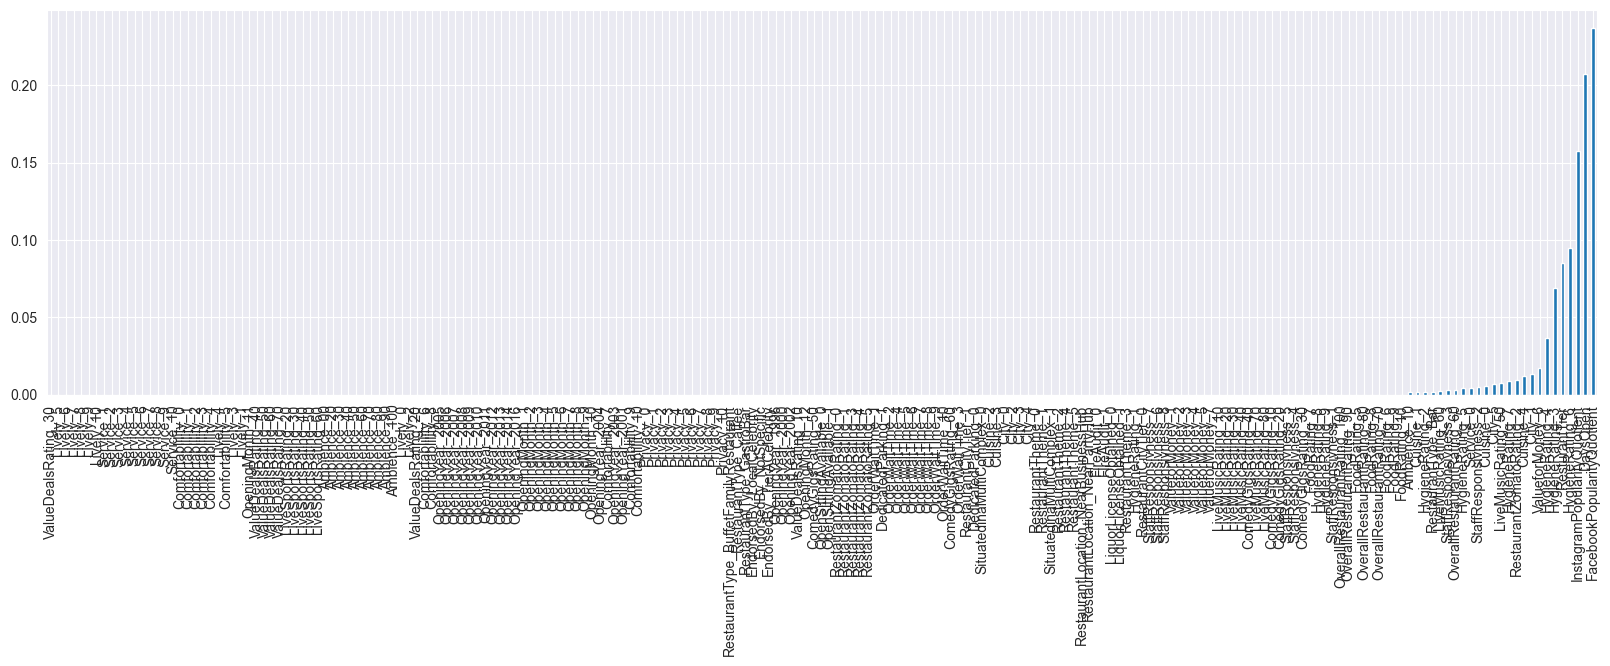

In [534]:
# # Random Forest Model Feature Importance
rf_feature_importance = pd.Series(index = train_inputs.columns, data = np.abs(rf_model_random.feature_importances_))
n_features = (rf_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')
rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (20,5));

## KNN Regressor

In [535]:
from sklearn.neighbors import KNeighborsRegressor

params_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
}

knn_model = KNeighborsRegressor()
knn_regressor = GridSearchCV(knn_model, params_knn, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
knn_regressor.fit(train_inputs, train_targets)
print(f'Optimal neighbors: {knn_regressor.best_params_["n_neighbors"]}')
print(f'Best score: {knn_regressor.best_score_}')

Optimal neighbors: 11
Best score: -0.5251426126524597


In [536]:
knn_model = KNeighborsRegressor(n_neighbors=knn_regressor.best_params_["n_neighbors"])
knn_model.fit(train_inputs, train_targets)
train_preds = knn_model.predict(train_inputs)
val_preds = knn_model.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_knn = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_knn = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE: {train_rmse_knn:n}')
print(f'Test RMSE: {test_rmse_knn:n}')

Train r2 score:  -3.566286628573166
Test r2 score:  0.0979954697981138
Train RMSE: 0.479182
Test RMSE: 0.518055


## Light GBM

In [537]:

import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "learning_rate": uniform(0.001,1),
    "n_estimators": randint(100,1000),
    "max_depth": randint(1,10),
    "colsample_bytree": uniform(0.1,0.8),
    "reg_alpha": [0.0001,0.001,0.01,0.1,1,10],
    "reg_lambda": [0.0001,0.001,0.01,0.1,1,10]
}

lgb_model = lgb.LGBMRegressor()
lgb_regressor = RandomizedSearchCV(lgb_model, params, cv=6, n_iter=100, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)
lgb_regressor.fit(train_inputs, train_targets)
print(f'Optimal lr: {lgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {lgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {lgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {lgb_regressor.best_score_}')

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 171
[LightGBM] [Info] Start training from score 17.086072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [538]:
lgb_model = lgb.LGBMRegressor(learning_rate=lgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=lgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=lgb_regressor.best_params_["n_estimators"], n_jobs=-1)
lgb_model.fit(train_inputs, train_targets)
train_preds = lgb_model.predict(train_inputs)
val_preds = lgb_model.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_lgb = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_lgb = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE XGB: {train_rmse_lgb:n}')
print(f'Test RMSE XGB: {test_rmse_lgb:n}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 171
[LightGBM] [Info] Start training from score 17.086072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

171 features with reduction of 15.76%


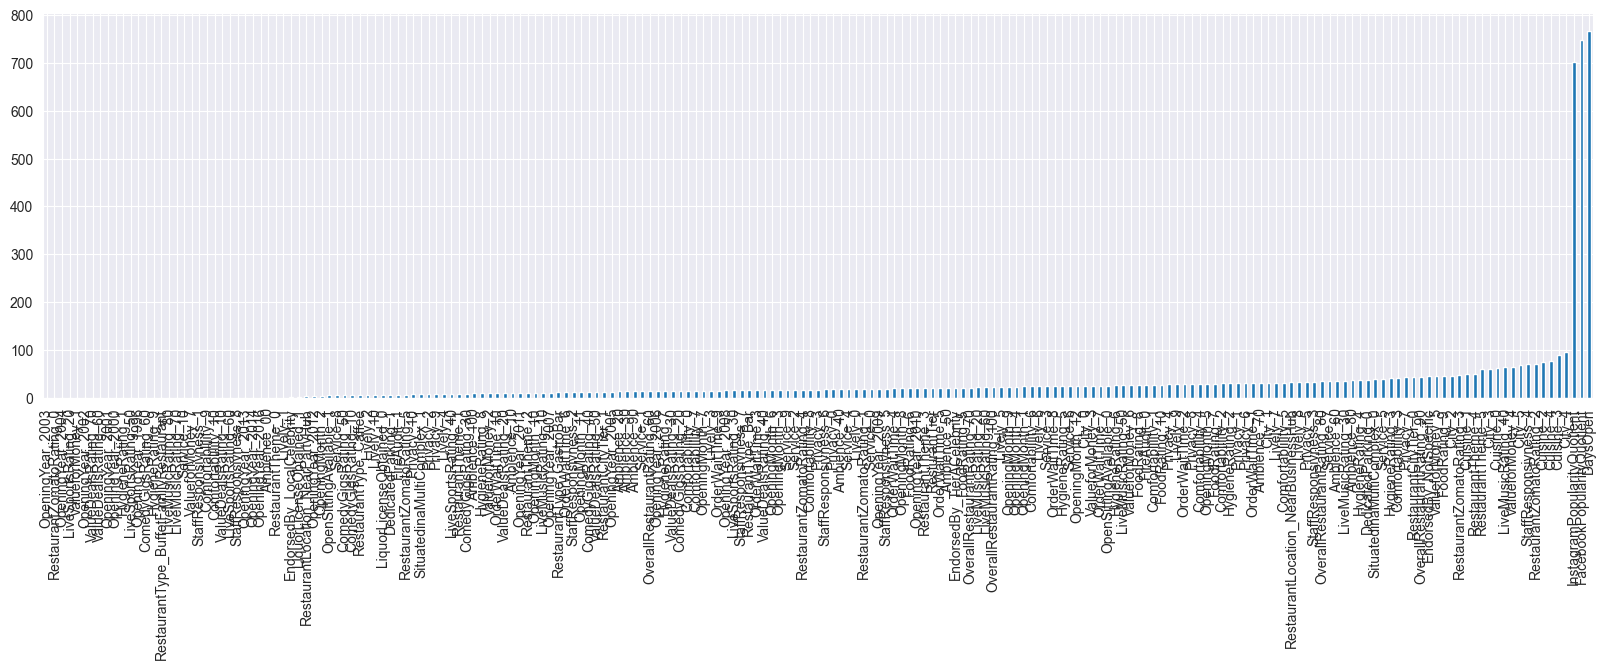

In [539]:
# XG Forest Model Feature Importance
rf_feature_importance = pd.Series(index = train_inputs.columns, data = np.abs(lgb_model.feature_importances_))
n_features = (rf_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')
rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (20,5));

## Stacking Regressor

### Stack 1 - Ridge Lasso RF

In [540]:
rf_model_en = RandomForestRegressor(max_depth=200, max_features=0.4, min_samples_leaf=3, 
                                 min_samples_split=6, n_estimators=30, n_jobs=-1, oob_score=True)
rf_model_en.fit(train_inputs, train_targets)
train_preds = rf_model_en.predict(train_inputs)
val_preds = rf_model_en.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_stack1 = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_stack1 = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE: {train_rmse_stack1:.4f}')
print(f'Test RMSE: {test_rmse_stack1:.4f}')

Train r2 score:  0.22252977690012787
Test r2 score:  0.20350904204079934
Train RMSE: 0.2868
Test RMSE: 0.4868


In [541]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# # get a stacking ensemble of models
# def get_stacking():
#     # define the base models
#     base_models = list()
#     base_models.append(('ridge', ridge_model))
#     base_models.append(('lasso', lasso_model))
#     base_models.append(('rf', rf_model_en))
#     # define meta learner model
#     learner = LinearRegression()
#     # define the stacking ensemble
#     model = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
#     return model
 
# # get a list of models to evaluate
# def get_models():
#     models = dict()
#     models['ridge'] = ridge_model
#     models['lasso'] = lasso_model
#     models['rf_en'] = rf_model_en
#     models['stacking'] = get_stacking()
#     return models
 
# # evaluate a given model using cross-validation
# def evaluate_model(model, X, y):
#     cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=19)
#     scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#     return scores

# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model, train_inputs, train_targets)
#     results.append(scores)
#     names.append(name)
#     print(f'{name} {mean(scores):.3f} {std(scores):.3f}')
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [542]:
# define the base models
base_models = list()
base_models.append(('ridge', ridge_model))
base_models.append(('lasso', lasso_model))
base_models.append(('xgb', xgb_model))
base_models.append(('lgm', lgb_model))
# define meta learner model
learner = LinearRegression()
# define the stacking ensemble
stack1 = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
# fit the model on all available data
stack1.fit(train_inputs, train_targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 171
[LightGBM] [Info] Start training from score 17.086072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

StackingRegressor(cv=10,
                  estimators=[('ridge', Ridge(alpha=20, solver='svd')),
                              ('lasso', Lasso(alpha=0.01)),
                              ('xgb',
                               XGBRegressor(alpha=3, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=Non...
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=70, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgm',
                               LGBMRegressor(alpha=3,
                                             colsample_bytree=0.8138956802238287,
                                             learning_rate=0.16805144831221552,
                                             max_depth=4, n_estimators=645,
                                             n_jobs=-1, subsample=0.5))],
                  final_estimator=LinearRegression())

In [543]:
train_preds = stack1.predict(train_inputs)
val_preds = stack1.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_stack1 = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_stack1 = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE: {train_rmse_stack1:.4f}')
print(f'Test RMSE: {test_rmse_stack1:.4f}')

Train r2 score:  -1.2060528205626713
Test r2 score:  0.25871921997737535
Train RMSE: 0.4083
Test RMSE: 0.4696


### Stack 2 - RF 1 / 2 / 3

In [544]:
# define the base models
base_model = list()
base_model.append(('rf1', rf_model_random))
base_model.append(('rf2', rf_model_en))
base_model.append(('rf3', RandomForestRegressor(max_depth=8, max_features=0.1, min_samples_leaf=3, 
                                                min_samples_split=2, n_estimators=250, n_jobs=-1, oob_score=False)))
# define meta learner model
learner = LinearRegression()
# define the stacking ensemble
stack2 = StackingRegressor(estimators=base_model, final_estimator=learner, cv=10)
# fit the model on all available data
stack2.fit(train_inputs, train_targets)

StackingRegressor(cv=10,
                  estimators=[('rf1',
                               RandomForestRegressor(max_depth=5,
                                                     max_features='auto',
                                                     min_samples_split=0.1434056586133429,
                                                     n_estimators=22, n_jobs=-1,
                                                     oob_score=True)),
                              ('rf2',
                               RandomForestRegressor(max_depth=200,
                                                     max_features=0.4,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     n_estimators=30, n_jobs=-1,
                                                     oob_score=True)),
                              ('rf3',
                               RandomForestRegressor(max_depth=8,
                                                     max_features=0.1,
                                                     min_samples_leaf=3,
                                                     n_estimators=250,
                                                     n_jobs=-1))],
                  final_estimator=LinearRegression())

In [545]:
train_preds = stack2.predict(train_inputs)
val_preds = stack2.predict(val_inputs)
print('Train r2 score: ', r2_score(train_preds, train_targets))
print('Test r2 score: ', r2_score(val_targets, val_preds))
train_rmse_stack2 = np.sqrt(mean_squared_error(train_preds, train_targets))
test_rmse_stack2 = np.sqrt(mean_squared_error(val_targets, val_preds))
print(f'Train RMSE: {train_rmse_stack2:.4f}')
print(f'Test RMSE: {test_rmse_stack2:.4f}')

Train r2 score:  0.009961204533825097
Test r2 score:  0.2477162415595363
Train RMSE: 0.3251
Test RMSE: 0.4731


## Model Comparision

In [546]:
from tabulate import tabulate 
#https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-table-style/
dict = {'Models'     : ['Linear Regression','Ridge Linear Regression','Lasso','XGB','RF -Random','KNN','LightGBM','Stack1','Stack2' ],
        'Train RMSE' : [train_rmse_linreg,train_rmse_ridge,train_rmse_lasso,train_rmse_xgb,train_rmse_rf_random,train_rmse_knn,train_rmse_lgb,train_rmse_stack1,train_rmse_stack2],
        'Test RMSE'  : [test_rmse_linreg,test_rmse_ridge,test_rmse_lasso,test_rmse_xgb,test_rmse_rf_random,test_rmse_knn,test_rmse_lgb,test_rmse_stack1,test_rmse_stack2]  
        }
df = pd.DataFrame(dict)
print(tabulate(df, headers = 'keys', tablefmt = 'psql')) 

+----+-------------------------+--------------+-------------+
|    | Models                  |   Train RMSE |   Test RMSE |
|----+-------------------------+--------------+-------------|
|  0 | Linear Regression       |     0.452096 |   1.687e+08 |
|  1 | Ridge Linear Regression |     0.456102 |   0.475013  |
|  2 | Lasso                   |     0.490361 |   0.487304  |
|  3 | XGB                     |     0.435689 |   0.471377  |
|  4 | RF -Random              |     0.492513 |   0.499628  |
|  5 | KNN                     |     0.479182 |   0.518055  |
|  6 | LightGBM                |     0.164845 |   0.506329  |
|  7 | Stack1                  |     0.40825  |   0.469638  |
|  8 | Stack2                  |     0.325084 |   0.47311   |
+----+-------------------------+--------------+-------------+


# Loading the Test Data and using the Test Data to Predict the target Variable

In [547]:
df_test.head()

,RegistrationNumber,Cuisine_0,Cuisine_1,Cuisine_2,Cuisine_3,Cuisine_4,City_0,City_1,City_2,City_3,...,OpeningMonth_3,OpeningMonth_4,OpeningMonth_5,OpeningMonth_6,OpeningMonth_7,OpeningMonth_8,OpeningMonth_9,OpeningMonth_10,OpeningMonth_11,OpeningMonth_12
3493,20001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3494,20002,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3495,20003,0,0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3496,20004,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3497,20005,0,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [548]:
## Using the model built on the Training set to predict on the Test Set
df_test_for_prediction = df_test.drop('RegistrationNumber',axis=1, inplace=False)
prediction_linreg = linreg_model.predict(df_test_for_prediction)
#prediction_rf = rf_model.predict(df_test_for_prediction)

#prediction_rf_random = rf_model_random.predict(df_test_for_prediction)

prediction_xgb_model = xgb_model.predict(df_test_for_prediction)
prediction_ridge_model = ridge_model.predict(df_test_for_prediction)
prediction_knn_model = knn_model.predict(df_test_for_prediction)

prediction_lasso_model = lasso_model.predict(df_test_for_prediction)
prediction_stack1_model = stack1.predict(df_test_for_prediction)
prediction_stack2_model = stack2.predict(df_test_for_prediction)

prediction_lgb_regressor = lgb_regressor.predict(df_test_for_prediction)


prediction_ridge_model

array([16.89687043, 17.41301665, 17.06367362, 17.32817281, 17.64486093,
       17.22220118, 17.07258151, 17.13007538, 17.01312883, 16.83202399,
       17.26172472, 17.32758112, 17.34756639, 16.81213555, 16.85393865,
       17.21624692, 17.35714342, 16.57356396, 17.2988815 , 16.86536751,
       16.85961349, 17.21503801, 16.99866104, 16.6353869 , 17.24261597,
       16.48128386, 17.19340248, 17.3302412 , 17.25779616, 16.87125812,
       17.54998348, 17.32311593, 16.87172384, 17.30918546, 16.93818219,
       16.77947585, 17.3664621 , 17.18389646, 16.87143091, 17.05993375,
       16.90449805, 16.94697462, 16.99615085, 16.92729133, 17.36473762,
       16.59563934, 16.81650552, 17.26142937, 17.28019352, 17.07087035,
       17.33046285, 17.26379303, 16.5810257 , 17.08825721, 17.20788618,
       17.03113183, 16.68174026, 17.22712086, 17.00592971, 17.04736414,
       16.69012578, 17.01885318, 17.26914728, 17.48588512, 17.11526188,
       17.21800312, 16.99271976, 16.31685239, 16.87245455, 17.43

# Saving the output in a data frame and then exporting it to a '.csv' file with the appropriate 'Registration Number'.

In [549]:
solution_df = pd.DataFrame(df_test['RegistrationNumber'])
solution_df

,RegistrationNumber
3493,20001
3494,20002
3495,20003
3496,20004
3497,20005
...,...
3988,20496
3989,20497
3990,20498
3991,20499


In [550]:
#solution_df['Annual Turnover'] = prediction_rf

#solution_df['Annual Turnover'] = np.expm1(prediction_rf).astype('int64')

#solution_df['Annual Turnover'] = np.expm1(prediction_rf_random).astype('int64')


#solution_df['Annual Turnover'] = np.expm1(prediction_xgb_model).astype('int64')

#solution_df['Annual Turnover'] = (np.expm1(np.square(prediction_ridge_model)).astype('int64') )         #BEST

#solution_df['Annual Turnover'] = np.expm1(prediction_knn_model).astype('int64')

#solution_df['Annual Turnover'] = np.expm1(prediction_lasso_model).astype('int64')

#solution_df['Annual Turnover'] = np.expm1(prediction_stack1_model).astype('int64')

#solution_df['Annual Turnover'] = np.expm1(prediction_stack2_model).astype('int64')
#solution_df['Annual Turnover'] = np.expm1(prediction_stack2_model).astype('int64')


#solution_df['Annual Turnover'] = (np.expm1(np.square(prediction_lgb_regressor)).astype('int64') )   

solution_df['Annual Turnover'] = (np.expm1(prediction_stack1_model).astype('int64') )   


solution_df = solution_df.rename(columns={'RegistrationNumber': 'Registration Number'})
solution_df

,Registration Number,Annual Turnover
3493,20001,22530003
3494,20002,35320838
3495,20003,25869517
3496,20004,35873063
3497,20005,43442064
...,...,...
3988,20496,31990661
3989,20497,25825165
3990,20498,32169781
3991,20499,46054879


In [551]:
## Setting the directory to export the file as a '.csv'

import os
os.chdir(folderPath + '/output/')

In [552]:
## Exporting the data frame to a '.csv' file and setting the index = False as we do want the index

solution_df.to_csv('Submission_stack1_log.csv',index=False)

# END